# Generative Adversarial Networks - GAN's

In this notebook we will generate images of handwritten digits using the MNIST dataset.

## Table of Contents

1. [Import libraries and define auxiliar functions](#1st)
2. [Hyperparameters of the model (easy to modify)](#2nd)
3. [Data preprocessing and EDA](#3rd)
4. [Building the model](#4th)
5. [Setting optimization and initialization](#5th)
6. [Hyperparameters of the model (easy to modify)](#6th)

<div id='1st'/> 

## 1. Import libraries and define auxiliar functions

Let us first import the necessary libraries:

In [96]:
import os #
import torch #
import torchvision #
import torch.nn as nn #
from torchvision import transforms #
from torchvision.utils import save_image #
# from torch.autograd import Variable
import matplotlib.pyplot as plt #
import numpy as np #
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# %matplotlib inline

Now, the functions auxiliar functions we will need:

In [97]:
# This goes from -1, 1 range to 0, 1 range.
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

<div id='2nd'/> 

## 2. Hyperparameters of the model (easy to modify)

These are the hyperparameters of the model:

In [98]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 3 # Initially 300
batch_size = 32

sample_dir = 'samples'
mod_dir = 'save/models'
vg_dir = 'save/values_graphs'


# What are we saving:
exc_time = 0         # UPDATE every time: 1 for the first time, etc... If I want to try sth 0 :)

# What are we loading:
ld_time = 0          # exc_time - 1  # Load the last model if not said otherwise
ld_epoch = 0

interpolate = False
NN = False

<div id='3rd'/>

## 3. Data preprocessing and EDA: exploring our dataset

Here we clean the data and process it so that we can work with it:

In [99]:
# The original pixel intensities range from 0 to 1. Using this transformation it switches to -1, 1.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std = (0.5,))])
mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True)

'mnist' is the training set of the MNIST dataset:

In [100]:
print(mnist)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


Recall that MNIST images have dimension 28x28

In [101]:
print(mnist[0][0][0][0])

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])


Here we can see the first data point. This is a tuple (image, target). In this case the number is 5.

In [102]:
print(mnist[0]) 

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -

This is the tensor image

In [103]:
print(mnist[0][0].shape)

torch.Size([1, 28, 28])


In [104]:
image = mnist[0][0].reshape(28,28)
print(image.shape)

torch.Size([28, 28])


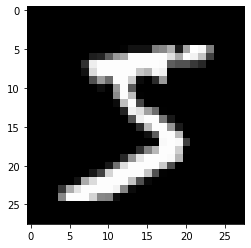

In [105]:
plt.imshow(image, cmap="gray")

In [106]:
print("The pixel intensities range from", int(image.min()), "to", int(image.max()))

The pixel intensities range from -1 to 1


Now that we know the structure of our dataset we can start building the model.

<div id='4th'/>

## 4. Building the model

Now, let us define the networks we will work with:

In [107]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())


G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Recall that nn.Sequential(...) are classes.

You can see the structure of the networks bellow. The first is the discriminateor and the second is the generator.

<img src="aux/Networks.jpg"  width="50%">

If we wanted to run this with a GPU we could then do:

``` python
D = D.cuda()
G = G.cuda()
```

<div id='5th'/>

## 5. Setting optimization and initialization

Let us now set the criteria and the optimizer:

In [108]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss() # criterion(x,y) = 1/N * sum(y_i*log(x_i) + (1-y_i)*log(1-x_i))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [109]:
nn.BCELoss()(torch.ones(10),torch.ones(10))

tensor(0.)

Now we initialize statistics that we want to keep track of:

In [110]:
# Statistics to be saved
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)
real_scores = np.zeros(num_epochs)
fake_scores = np.zeros(num_epochs)

In [111]:
total_step = len(data_loader)

If we have models saved we can load them:

In [112]:
# Load the model: the last one is G--[exc_time - 1]--[epoch].ckpt

state_dict = torch.load('G--{}--{}'.format(ld_time,ld_epoch))
G.load_state_dict(state_dict)
state_dict = torch.load('D--{}--{}'.format(ld_time,ld_epoch))
D.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'G--0--0'

Let us train our model now :)

Epoch [0/3], Step [200/1875], d_loss: 0.0541, g_loss: 3.8859, D(x): 0.99, D(G(z)): 0.04
Epoch [0/3], Step [400/1875], d_loss: 0.1350, g_loss: 5.5454, D(x): 0.97, D(G(z)): 0.09
Epoch [0/3], Step [600/1875], d_loss: 0.0256, g_loss: 5.5136, D(x): 0.99, D(G(z)): 0.01
Epoch [0/3], Step [800/1875], d_loss: 0.0616, g_loss: 5.8069, D(x): 0.96, D(G(z)): 0.01
Epoch [0/3], Step [1000/1875], d_loss: 0.0517, g_loss: 4.2335, D(x): 0.99, D(G(z)): 0.04
Epoch [0/3], Step [1200/1875], d_loss: 0.0651, g_loss: 5.1253, D(x): 0.99, D(G(z)): 0.06
Epoch [0/3], Step [1400/1875], d_loss: 0.1696, g_loss: 3.1909, D(x): 0.93, D(G(z)): 0.07
Epoch [0/3], Step [1600/1875], d_loss: 0.9311, g_loss: 2.9886, D(x): 0.81, D(G(z)): 0.42
Epoch [0/3], Step [1800/1875], d_loss: 0.1609, g_loss: 3.9844, D(x): 0.99, D(G(z)): 0.13


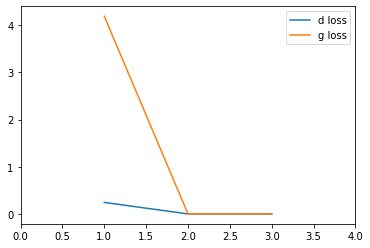

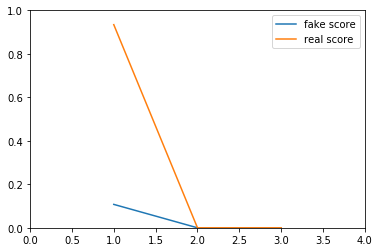

Epoch [1/3], Step [200/1875], d_loss: 0.3167, g_loss: 3.1061, D(x): 0.90, D(G(z)): 0.15
Epoch [1/3], Step [400/1875], d_loss: 0.1419, g_loss: 3.6668, D(x): 0.92, D(G(z)): 0.04
Epoch [1/3], Step [600/1875], d_loss: 0.4955, g_loss: 1.8643, D(x): 0.90, D(G(z)): 0.30
Epoch [1/3], Step [800/1875], d_loss: 0.3559, g_loss: 3.8318, D(x): 0.85, D(G(z)): 0.02
Epoch [1/3], Step [1000/1875], d_loss: 0.3271, g_loss: 3.7439, D(x): 0.89, D(G(z)): 0.11
Epoch [1/3], Step [1200/1875], d_loss: 0.1911, g_loss: 4.1302, D(x): 0.99, D(G(z)): 0.16
Epoch [1/3], Step [1400/1875], d_loss: 0.3495, g_loss: 3.0961, D(x): 0.94, D(G(z)): 0.22
Epoch [1/3], Step [1600/1875], d_loss: 0.1694, g_loss: 3.7979, D(x): 0.94, D(G(z)): 0.06
Epoch [1/3], Step [1800/1875], d_loss: 0.1559, g_loss: 3.5198, D(x): 0.99, D(G(z)): 0.13


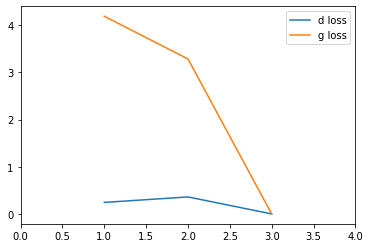

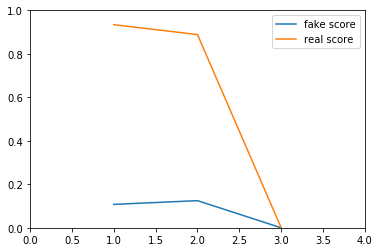

Epoch [2/3], Step [200/1875], d_loss: 0.2750, g_loss: 1.4108, D(x): 0.94, D(G(z)): 0.14
Epoch [2/3], Step [400/1875], d_loss: 0.0971, g_loss: 4.4759, D(x): 0.97, D(G(z)): 0.06
Epoch [2/3], Step [600/1875], d_loss: 0.1697, g_loss: 4.2213, D(x): 0.93, D(G(z)): 0.01
Epoch [2/3], Step [800/1875], d_loss: 0.0936, g_loss: 5.8709, D(x): 0.95, D(G(z)): 0.01
Epoch [2/3], Step [1000/1875], d_loss: 0.0749, g_loss: 5.2937, D(x): 0.95, D(G(z)): 0.01
Epoch [2/3], Step [1200/1875], d_loss: 0.2589, g_loss: 3.5602, D(x): 0.95, D(G(z)): 0.16
Epoch [2/3], Step [1400/1875], d_loss: 0.2020, g_loss: 6.9339, D(x): 0.95, D(G(z)): 0.01
Epoch [2/3], Step [1600/1875], d_loss: 0.2824, g_loss: 5.7103, D(x): 0.90, D(G(z)): 0.01
Epoch [2/3], Step [1800/1875], d_loss: 0.1915, g_loss: 3.1327, D(x): 0.97, D(G(z)): 0.13


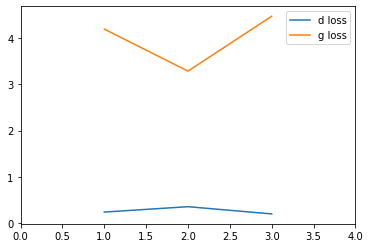

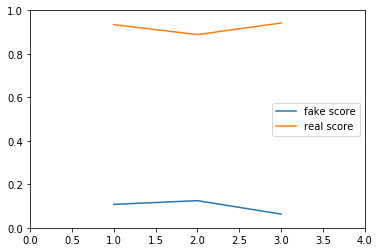

In [113]:
for epoch in range(num_epochs):
    
    for i, (images, _) in enumerate(data_loader):
        
        # Here we resize the images (batch_size x 784)
        images = images.view(batch_size, -1) #.cuda()
        
        # Create the labels which are later used as input for the BCE loss: 0 for fake and 1 for real.
        real_labels = torch.ones(batch_size, 1) #.cuda()
        fake_labels = torch.zeros(batch_size, 1) #.cuda()

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # REAL IMAGES LOSS:
        # d_loss_real = 1/N * sum(log(D(images))) = E_(p_data)[log(D(x))]
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # FAKE IMAGES LOSS:
        # d_loss_fake = 1/N * sum(log(1-D(G(fake_images)))) = E_(p_z)[log(1-D(G(z)))]
        z = torch.randn(batch_size, latent_size) #.cuda()
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # BACKPROP AND OPTIMIZE:
        d_loss = d_loss_real + d_loss_fake  # this is a tensor, and has .required_grads = True :)
        reset_grad()                        # this sets gradients to 0 so that they don't accumulate
        d_loss.backward()                   # gradients backprop through the graph
        d_optimizer.step()                  # this changes the values of the parameters following the Adam algorithm.
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # FAKE IMAGES LOSS:
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z))) [justified in original GANs paper]
        z = torch.randn(batch_size, latent_size) #.cuda()
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)

        # BACKPROP AND OPTIMIZE:
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # =================================================================== #
        #                          Update Statistics                          #
        # =================================================================== #
        
        # This averages the losses and scores of the epoch across the batches (i).
        d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss*(1./(i+1.)) 
        g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss*(1./(i+1.))
        
        # Same as above but these are vectors for each epoch
        real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean()*(1./(i+1.)) 
        fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean()*(1./(i+1.))
        
        # Displays every 200 batches the results of the current batch:
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss, g_loss,
                          real_score.mean(), fake_score.mean()))

    
    # ================================================================ #
    #   FOR EACH EPOCH (when finished optimization through batches):   #
    # ================================================================ #

    # Save sampled images (the ones from last batch)
    fake_images = denorm(fake_images.view(fake_images.size(0), 1, 28, 28)).round() # rounded 0, 1
    save_image(fake_images, os.path.join(sample_dir, 'fake_images-{}-{}.png'.format(exc_time, epoch+1)))

    # Save Statistics epoch by epoch so that we can have them even if we cancel the execution.
    np.save(os.path.join(vg_dir, 'd_losses_{}.npy'.format(exc_time)), d_losses)
    np.save(os.path.join(vg_dir, 'g_losses_{}.npy'.format(exc_time)), g_losses)
    np.save(os.path.join(vg_dir, 'fake_scores_{}.npy'.format(exc_time)), fake_scores)
    np.save(os.path.join(vg_dir, 'real_scores_{}.npy'.format(exc_time)), real_scores)
    
    # This is a dynamic way of showing the plot. We show the current plots and save it as well.
    
    # LOSSES D and G:
    plt.figure()
    plt.xlim(0,num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), d_losses, label='d loss')
    plt.plot(range(1, num_epochs + 1), g_losses, label='g loss')
    plt.legend()
    plt.savefig(os.path.join(vg_dir, 'loss_{}.pdf'.format(exc_time)))
    plt.show()
    
    # SCORES real vs fake:
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.ylim(0, 1)
    plt.plot(range(1, num_epochs + 1), fake_scores, label='fake score')
    plt.plot(range(1, num_epochs + 1), real_scores, label='real score')
    plt.legend()
    plt.savefig(os.path.join(vg_dir, 'accuracy_{}.pdf'.format(exc_time)))
    plt.show()

    # Save model at checkpoints: execution time + epoch.
    if (epoch+1) % 10 == 0:
        torch.save(G.state_dict(), os.path.join(mod_dir, 'G--{}--{}.ckpt'.format(exc_time, epoch+1)))
        torch.save(D.state_dict(), os.path.join(mod_dir, 'D--{}--{}.ckpt'.format(exc_time, epoch+1)))

* How can I recuperate all the losses and concatenate them together? + Do the final loss and score graph.

In [ ]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Extra things...

In [ ]:
# Once the model has been trained, let us interpolate two random points in the latent space.
# z_1*alpha + (1-alpha)*z_2, alpha from 0 to 1
if interpolate == True:
	z1 = torch.randn(latent_size) #.cuda()
	z1 = Variable(z1)
	z2 = torch.randn(latent_size) #.cuda()
	z2 = Variable(z2)
	for i in range(0,51): # alpha = i/50
		alpha = i/50.0
		z = (1-alpha)*z1 + alpha*z2
		fake_image = G(z)
		fake_image = denorm(fake_image.view(1, 28, 28)).round() # rounded
		save_image(fake_image.data, os.path.join(sample_dir, 'interp-{}.png'.format(i)))

In [ ]:
# NEAREST NEIGHBOURS:
# Images 28x28, search the closest one.
# function(generated_image) --> closest training_image
if NN == True:
	aux_data_loader = torch.utils.data.DataLoader(dataset=mnist,
	                                              batch_size=1,
	                                              shuffle=False)

	def nearest_gt(generated_image):
	    min_d = 0
	    closest = False
	    for i, (image, _) in enumerate(aux_data_loader):
	        image = denorm(image.view(1, 28, 28)).round() # all distances in binary...
	        d = torch.dist(generated_image,image) # must be torch tensors (1,28,28)
	        if i == 0 or d < min_d:
	            min_d = d
	            closest = image

	    return closest

	# Calculate NN musaic 8x3
	z = torch.randn(24, latent_size)
	fake_images = G(z)
	fake_images = denorm(fake_images.view(24, 1, 28, 28)).round()
	save_image(fake_images.data, os.path.join(sample_dir, 'f24.png'))
	NN = torch.zeros(24, 1, 28, 28)
	for i in range(0,24):
		NN[i] = nearest_gt(fake_images[i])
		print(i)

	save_image(NN.data, os.path.join(sample_dir, 'NN24.png'))

## 7. Extras